In [3]:
from bg_atlasapi import show_atlases
show_atlases()
from bg_atlasapi.bg_atlas import BrainGlobeAtlas


╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  allen_mouse_25um                      ✔          ✔          1.2           1.2       │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_50um                                                          1.2       │
│  allen_mouse_100um                                                         1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  allen_human_500um                                                         0.1       │
│  kim_mouse_10um                                                            1.0       │
│  kim_mouse_25um                                                            1.0       │
│  kim_mouse_50um                                                            1.0       │
│  kim_mouse_100um                                                           1.0       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.0       │
│  azba_zfish_4um                                                            1.1       │
│  whs_sd_rat_39um                                                           1.0       │
│  perens_lsfm_mouse_20um                                                    1.0       │
│  admba_3d_e11_5_mouse_16um                                                 1.0       │
│  admba_3d_e13_5_mouse_16um                                                 1.0       │
│  admba_3d_e15_5_mouse_16um                                                 1.0       │
│  admba_3d_e18_5_mouse_16um                                                 1.0       │
│  admba_3d_p4_mouse_16.752um                                                1.0       │
│  admba_3d_p14_mouse_16.752um                                               1.0       │
│  admba_3d_p28_mouse_16.752um                                               1.0       │
│  admba_3d_p56_mouse_25um                                                   1.0       │
│  princeton_mouse_20um                                                      1.0       │
│  kim_dev_mouse_stp_10um                                                    1.1       │
│  kim_dev_mouse_idisco_10um                                                 1.1       │
│  kim_dev_mouse_mri_a0_10um                                                 1.1       │
│  kim_dev_mouse_mri_adc_10um                                                1.1       │
│  kim_dev_mouse_mri_dwi_10um                                                1.1       │
│  kim_dev_mouse_mri_fa_10um                                                 1.1       │
│  kim_dev_mouse_mri_mtr_10um                                                1.1       │
│  kim_dev_mouse_mri_t2_10um                                                 1.1       │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [19]:
atlas = BrainGlobeAtlas("osten_mouse_100um")

Bgatlas_api: osten_mouse_100um not found locally. Downloading...

Output()

In [20]:
reference_image = atlas.reference
print(reference_image.shape)

(132, 80, 114)


In [21]:
import matplotlib.pyplot as plt

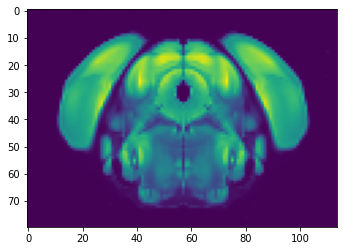

In [23]:
plt.imshow(reference_image[100,:,:])

In [24]:
reference_image[100,:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]], dtype=uint16)

In [ ]:
import numpy as np

In [ ]:
annotation_image = atlas.annotation
print(annotation_image.shape)

(1024, 512, 512)


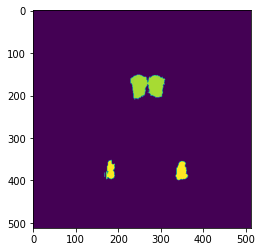

In [25]:
plt.imshow(annotation_image[100,:,:])

In [26]:
len(np.unique(annotation_image.flatten()))

223

In [27]:
annotation_image[100,:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [28]:
atlas.lookup_df.head(8)

,acronym,id,name
0,root,997,root
1,grey,8,Basic cell groups and regions
2,CH,567,Cerebrum
3,CTX,688,Cerebral cortex
4,CTXpl,695,Cortical plate
5,Isocortex,315,Isocortex
6,FRP,184,"Frontal pole, cerebral cortex"
7,FRP1,68,"Frontal pole, layer 1"


In [30]:
from pprint import pprint
CTX = atlas.structures["CTX"]
pprint(CTX)

{'acronym': 'CTX',
 'id': 688,
 'mesh': None,
 'mesh_filename': WindowsPath('C:/Users/Dan/.brainglobe/osten_mouse_100um_v1.1/meshes/688.obj'),
 'name': 'Cerebral cortex',
 'rgb_triplet': [255, 255, 255],
 'structure_id_path': [997, 8, 567, 688]}


In [31]:
atlas.metadata

{'name': 'osten_mouse',
 'citation': 'Kim et al. 2015, https://doi.org/10.1016/j.celrep.2014.12.014',
 'atlas_link': 'https://doi.org/10.1016/j.celrep.2014.12.014',
 'species': 'Mus musculus',
 'symmetric': True,
 'resolution': [100.0, 100.0, 100.0],
 'orientation': 'asr',
 'version': '1.1',
 'shape': [132, 80, 114],
 'trasform_to_bg': [[1.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0]],
 'additional_references': []}

In [34]:
3900 * np.cos(np.deg2rad(90))

2.388061258337339e-13